In [1]:
import os, sys
import scipy
import math
import warnings
import random
import tqdm
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import xgboost as xgb
from datetime import timedelta
from extract_features import get_time_series_features, get_freq_domain_features, get_similarity_features
from sklearn.model_selection import train_test_split, KFold, cross_val_score, LeaveOneGroupOut, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score, roc_auc_score, plot_confusion_matrix
from imblearn.over_sampling import SMOTE

warnings.filterwarnings('ignore')

ROOT_DIR = os.getcwd()

## Assignment 2: Activity Recognition
**Name: Ha Le**
**Date: Oct. 11st, 2022**

### Step 1: Load the Data

The chunk of code below clean and load the raw dataset from the assignment page. Upon viewing the file, I saw that many datapoints are not seperated by line, so we'll have to clean up a bit before we can use pandas to import the dataset.

In [2]:
# First, open the file
data_file = open(ROOT_DIR + '/../data/raw/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt', "r")
# print(data_file.read())
#split the data points by ";" and store them in a list
data = data_file.read().split(';')
# print(data)
#remove the new line symbol from each of the items in the list
data = [x.replace('\n', '') for x in data]
#write the data to a new file
with open(ROOT_DIR + '/../data/clean/WISDM_ar_v1.1_raw.txt', 'w') as f:
    for item in data:
        if len(item.split(',')) !=  6:
            continue
        f.write("%s\n" % item)

# Importing the dataset
dataset = pd.read_csv(ROOT_DIR + '/../data/clean/WISDM_ar_v1.1_raw.txt', header=None, names=['user-id', 'activity', 'timestamp', 'x', 'y', 'z'])
# remove all rows with timestamp = 0
dataset = dataset[dataset['timestamp'] != 0]
# convert the timestamp to a datetime object
dataset['timestamp'] = pd.to_datetime(dataset['timestamp'])
print(f"Length of the dataset: {len(dataset)}")
dataset.head()

Length of the dataset: 1073629


,user-id,activity,timestamp,x,y,z
0,33,Jogging,1970-01-01 13:38:25.962326,-0.694638,12.680544,0.503953
1,33,Jogging,1970-01-01 13:38:26.062271,5.012288,11.264028,0.953424
2,33,Jogging,1970-01-01 13:38:26.112167,4.903325,10.882658,-0.081722
3,33,Jogging,1970-01-01 13:38:26.222305,-0.612916,18.496431,3.023717
4,33,Jogging,1970-01-01 13:38:26.332290,-1.184970,12.108489,7.205164


### Step 2: Data Cleaning and Pre-processing

Next, we will need to seperate our dataset into different smaller dataset based on the user-id, so we can perform noise removal and segmentation seperatedly for different subjects:

In [3]:
# remove null values from the dataset
dataset = dataset.dropna()

#calculate the magnitude of the acceleration
dataset['magnitude'] = np.sqrt(dataset['x']**2 + dataset['y']**2 + dataset['z']**2)

# see the number of rows in the dataset left
print(f"Length of the dataset after removing null values: {len(dataset)}")
#  break the dataset into different smaller datasets based on the user-id
user_ids = dataset['user-id'].unique()
# print(user_ids)
# create a dictionary to store the different datasets
user_data = {}
for user_id in user_ids:
    user_data[user_id] = dataset[dataset['user-id'] == user_id]
    # sort the dataset based on the timestamp in case we have some out of order data
    user_data[user_id] = user_data[user_id].sort_values(by='timestamp')
# print(user_data)

Length of the dataset after removing null values: 1073629


We want to visualize some of the data from the subjects. I wrote a function, given the user-id, will draw the raw accelerometer data of that user:

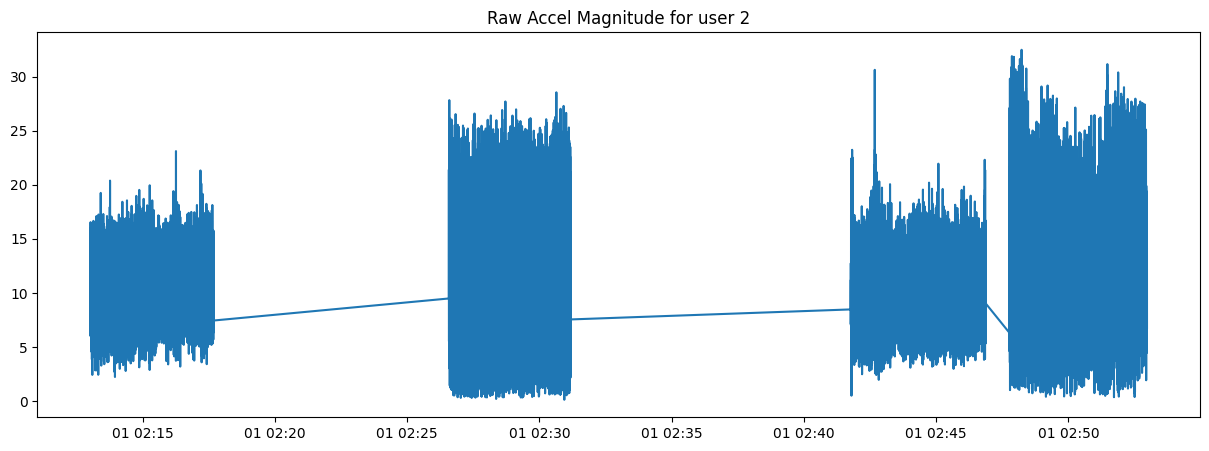

In [4]:
def visualize_raw_accel(timestamp, signal, title):
    """
    Visualize the signal data for a given list of accelerations
    :param user_id: the user id to visualize
    :return: None
    """
    plt.figure(figsize=(15, 5))
    # print("pass 1")
    plt.plot(timestamp, signal)
    plt.title(title)
    plt.show()

#test the function on a user
visualize_raw_accel(user_data[2]['timestamp'], user_data[2]['magnitude'], 'Raw Accel Magnitude for user 2')

It seems like the data is not collected consecutively, but seperated into several chunks. Hence, when we segmented the data, we should take this into consideration. To make life easier, let's further divided our dataframes into different smaller dataframe where the timestamps are continuous.

I wrote a function, seperate_df_based_on_timestamp() that take a user ID, and seperate the dataset for that user into smaller dataframes, each of them are temporal consecutive data represented new chunk of activities. To test if the function behaves according to our intention, we can test the result against user 2. From the graph above, it looks like user 2 has 4 different chunks of activities.

In [5]:
def seperate_df_based_on_timestamp(user_id: int):
    '''
    This function is used to seperate the dataframe based on the timestamp.
    If the time difference between two consecutive rows is greater than 2 
    second, then we will consider it as a new chunk of activities.
    If the chunk has more than 1 activity, than we will divide it further.
    :param user_id: the user id to visualize
    :return: List of dataframes
    '''

    user_df = user_data[user_id]
    # sort the dataset based on the timestamp in case we have some out of order data
    user_df = user_df.sort_values(by='timestamp')
    #create another column to store the time difference between two consecutive rows
    user_df['time_diff'] = user_df['timestamp'].diff().dt.total_seconds()
    #reset the index
    user_df = user_df.reset_index(drop=True)

    #get the entries in time_diff column where the time difference is greater than 1 second
    time_diff = [0] + user_df[user_df['time_diff'] > 2].index.tolist() + [len(user_df) - 1]

    #remove the time_diff column
    user_df = user_df.drop(columns=['time_diff'])

    df_list = []
    # split the datafram at the indices where the time difference is greater than 1 second
    for index in range(len(time_diff) - 1):
        # print("split points: ", time_diff[index], time_diff[index + 1])
        new_chunk = user_df.iloc[time_diff[index]:time_diff[index + 1]]
        # print(new_chunk)
        df_list.append(new_chunk)
    
    return df_list

#test the function on a user
user2_df_list = seperate_df_based_on_timestamp(2)
print(f"Number of dataframes: {len(user2_df_list)}")



Number of dataframes: 4


It looks like the function is working as we intended. Now, we want to apply the function to every user, and store all the dataframe into a dictionary, for the sake of retrieval.

I also made a report of all the dataframe to examine if there is anything weird going on (very short chunk, for example). You can view the full version of the report [here]("Assignment2/reports/user_activity_chunk_summary.csv") (it's in the "report/user_activity_chunk_summary.csv" file).

In [6]:
user_id_lst = dataset['user-id'].unique()
user_id_lst.sort()
user_activity_dict = {i:{} for i in user_id_lst}

for user_id in user_id_lst:
    # get the list of activity dataframes for the user
    user_df_list = seperate_df_based_on_timestamp(user_id)

    activity_chunk_id = 0
    #store this in the user_activity_dict
    for activity_df in user_df_list:
        # if the length of the dataframe is less than 100, then we will not consider it
        # as a valid activity (since it is too short - less than 5 seconds)
        if len(activity_df) < 100:
            continue
        #store the activity dataframe in the dictionary
        user_activity_dict[user_id][activity_chunk_id] = activity_df
        activity_chunk_id += 1

#summary of the user_activity_dict
# create a dataframe to store the summary of the user_activity_dict
user_activity_summary = pd.DataFrame(columns=['user-id', 'activity', 'start-time', 'end-time', 'duration', 'num-rows', 'num-activities'])
# iterate through the user_activity_dict and store the summary in the dataframe
for user_id in user_activity_dict.keys():
    for activity_chunk_id in user_activity_dict[user_id].keys():
        # get the activity dataframe
        activity_df = user_activity_dict[user_id][activity_chunk_id]
        if len(list(activity_df["timestamp"])) == 0:
            print("Empty dataframe")
            print("User ID: ", user_id)
            print("Activity Chunk ID: ", activity_chunk_id)
            continue
        # get the start and end time
        start_time = list(activity_df['timestamp'])[0]
        end_time = list(activity_df['timestamp'])[-1]
        # get the duration
        duration = end_time - start_time
        # convert the duration to seconds
        duration = duration.total_seconds()
        # get the number of rows
        num_rows = len(activity_df)
        # get the activity
        activity = activity_df['activity'].iloc[0]
        #get the number of activities
        num_activities = len(activity_df['activity'].unique())
        # add the summary to the dataframe
        user_activity_summary = user_activity_summary.append({'user-id': user_id, 'activity': activity, 'start-time': start_time, 
            'end-time': end_time, 'duration': duration, 'num-rows': num_rows, "num_activities": num_activities}, ignore_index=True)

# export the report to a csv file
user_activity_summary.to_csv(ROOT_DIR + '/../reports/user_activity_chunk_summary.csv', index=False)
# print the head of the summary
print(user_activity_summary.head())


  user-id activity                  start-time                    end-time  \
0       1  Walking  1970-01-01 01:23:11.922345  1970-01-01 01:28:51.942304   
1       1  Jogging  1970-01-01 01:29:34.662305  1970-01-01 01:33:44.562299   
2       1  Walking  1970-01-01 01:34:27.992292  1970-01-01 01:37:01.602369   
3       1  Walking  1970-01-01 01:37:05.572339  1970-01-01 01:39:34.872327   
4       1  Jogging  1970-01-01 01:39:55.682355  1970-01-01 01:44:58.492292   

     duration num-rows num-activities  num_activities  
0  340.019959     6801            NaN             1.0  
1  249.899994     4999            NaN             1.0  
2  153.610077     3073            NaN             1.0  
3  149.299988     2987            NaN             1.0  
4  302.809937     6057            NaN             1.0  


Let's visualize one of the signal to see if we need to do any noise removal beforehand. 

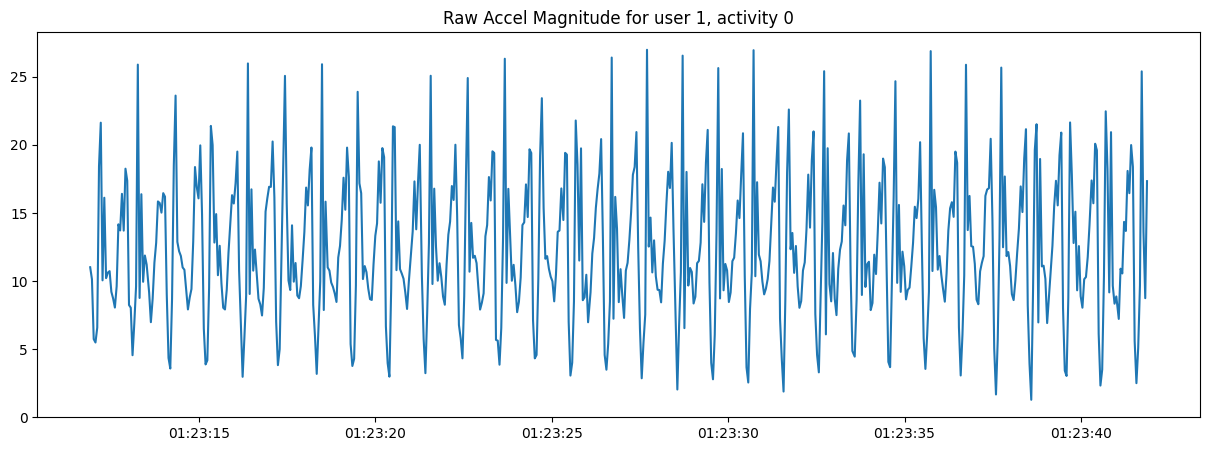

In [7]:
# plot the magnitude signal for the first chunk of activity for user 1, but only plot the first 600 rows (roughly 30 seconds)
visualize_raw_accel(user_activity_dict[1][0]['timestamp'][:600], user_activity_dict[1][0]['magnitude'][:600], 'Raw Accel Magnitude for user 1, activity 0')


The signal looks quite crowded and noisy. I will use a simple low-pass filter (similar to what I did in project 1) to remove some of the noise.

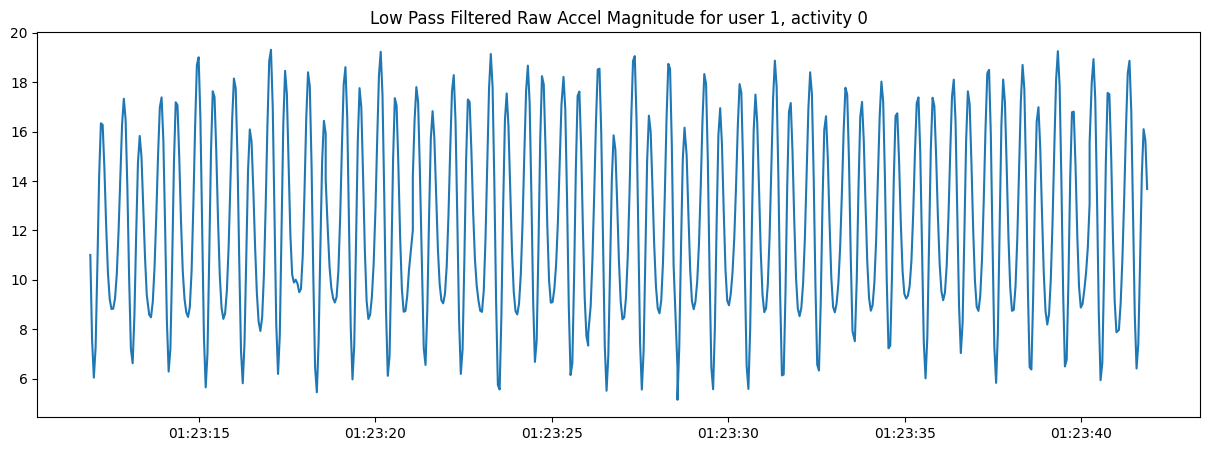

In [8]:
def low_pass_filter(data, cutoff, fs, order=5):
    '''
    This function is used to apply a low pass filter to the data
    :param data: the data to filter
    :param cutoff: the cutoff frequency
    :param fs: the sampling frequency
    :param order: the order of the filter
    :return: the filtered data
    '''
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = scipy.signal.butter(order, normal_cutoff, btype='low', analog=False)
    y = scipy.signal.filtfilt(b, a, data)
    return y

#set the sampling frequency
fs = 20
#set the cutoff frequency
cutoff = 3

#apply the low pass filter to the magnitude signal
user_activity_dict[1][0]['magnitude'] = low_pass_filter(user_activity_dict[1][0]['magnitude'], cutoff, fs)

#plot the magnitude signal for the first chunk of activity for user 1, but only plot the first 600 rows (roughly 30 seconds)
visualize_raw_accel(user_activity_dict[1][0]['timestamp'][:600], user_activity_dict[1][0]['magnitude'][:600], 'Low Pass Filtered Raw Accel Magnitude for user 1, activity 0')

The signal after applying the low-pass filter looks pretty clean. Let's apply it to all other dataframes, and plot the magnitude for the random activity chunk of a random user to confirm that our filter works:

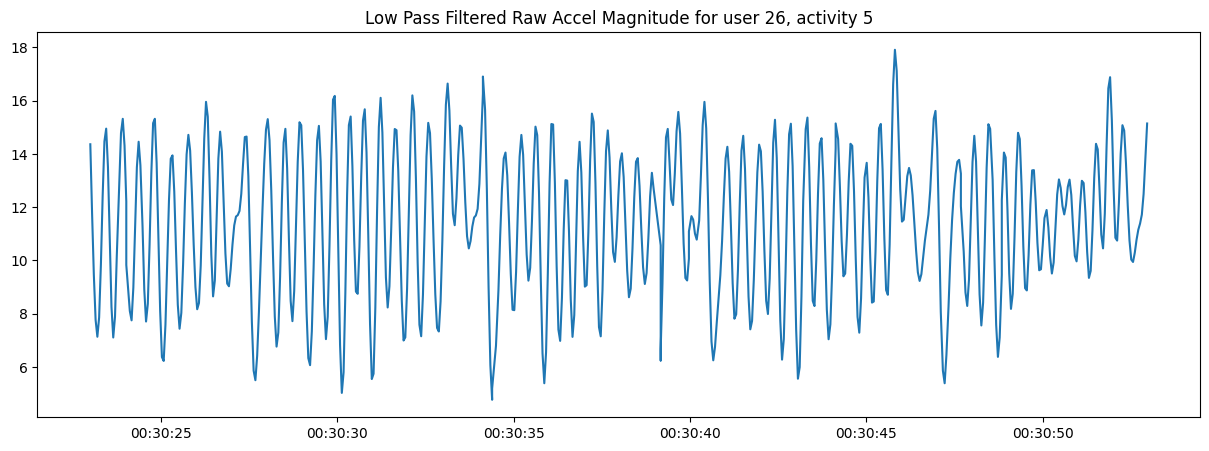

In [9]:
# apply the low pass filter to all the data
for user_id in user_activity_dict.keys():
    for activity_chunk_id in user_activity_dict[user_id].keys():
        # get the activity dataframe
        activity_df = user_activity_dict[user_id][activity_chunk_id]
        # apply the low pass filter to the magnitude signal
        activity_df['magnitude'] = low_pass_filter(activity_df['magnitude'], cutoff, fs)
        # apply the low pass filter to the x signal
        activity_df['x'] = low_pass_filter(activity_df['x'], cutoff, fs)
        # apply the low pass filter to the y signal
        activity_df['y'] = low_pass_filter(activity_df['y'], cutoff, fs)
        # apply the low pass filter to the z signal
        activity_df['z'] = low_pass_filter(activity_df['z'], cutoff, fs)
        # store the activity dataframe back in the dictionary
        user_activity_dict[user_id][activity_chunk_id] = activity_df

# plot the magnitude signal for a random chunk of activity for a random user, but only plot the first 600 rows (roughly 30 seconds)
user_id = random.choice(list(user_activity_dict.keys()))
random_chunk_id = random.randint(0, len(user_activity_dict[user_id].keys()) - 1)
try:
    visualize_raw_accel(user_activity_dict[user_id][random_chunk_id]['timestamp'][:600], user_activity_dict[user_id][random_chunk_id]['magnitude'][:600], f'Low Pass Filtered Raw Accel Magnitude for user {user_id}, activity ' + str(random_chunk_id))
except Exception as e:
    print(user_id, random_chunk_id)

### Step 3: Segmenting the Data

Now that we are done with the data cleaning process, we can start segmenting our data to feed it to a classifier. I will be using a window size of 10 seconds, according to the recommendation of the original paper:

In [10]:
# initialize the window size (in seconds)
window_size_in_seconds = 10

def segmenting_signal(signal_df: pd.DataFrame, window_size: timedelta, overlap_percent=0.5):
    '''
    This function segments the signal into overlapping windows of size window_size
    with overlap_percent overlap
    :param signal: the signal to segment
    :param window_size: the size of the window (in timedeltas)
    :param overlap_percent: the percentage of overlap between the windows
    :return: a list of the segmented signal
    '''

    # convert the window size to seconds
    window_size = window_size.total_seconds()
    # calculate the number of samples in the window
    window_samples = int(window_size * fs)
    # calculate the number of samples to overlap
    overlap_samples = int(window_samples * overlap_percent)
    # calculate the number of samples to step
    step_samples = window_samples - overlap_samples
    # calculate the number of windows
    num_windows = int((len(signal_df) - window_samples) / step_samples) + 1
    # create a list to store the segmented signal
    segmented_signal = []
    # iterate through the number of windows
    for i in range(num_windows):
        # get the start and end indices
        start_index = i * step_samples
        end_index = start_index + window_samples
        # get the window
        window = signal_df[start_index:end_index]
        # append the window to the segmented signal if there is only one activity in the window
        if len(window['activity'].unique()) == 1:
            segmented_signal.append(window)
    return segmented_signal
    
# test the function on the first chunk of activity for user 1
segmented_signal = segmenting_signal(user_activity_dict[1][0], timedelta(seconds=window_size_in_seconds))
# print the number of windows
print("Number of window: ",len(segmented_signal))
# print the length of the first window
print("Length of windows: ", [len(window) for window in segmented_signal])

Number of window:  67
Length of windows:  [200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200]


The function seems to work well. Let apply it to all the dataset.

In [11]:
# segment the signal for all the data
segmented_dfs =[]
for user_id in user_activity_dict.keys():
    for activity_chunk_id in user_activity_dict[user_id].keys():
        # get the activity dataframe
        activity_df = user_activity_dict[user_id][activity_chunk_id]
        # segment the signal
        segmented_signal = segmenting_signal(activity_df, timedelta(seconds=window_size_in_seconds))
        # append the segmented signal to the list
        segmented_dfs.extend(segmented_signal)

#print how many segments there are
print("Number of segments: ", len(segmented_dfs))

Number of segments:  10086


### Step 4: Feature Extraction

Now that we have the segmented dataframes, we want to extract meaningful features from our signals. For each segment_df, we will extract the time/frequency domain features for the magnitude signal, and the activity label. 

I will also export the new dataset to a csv file.

In [13]:
# extract the features from the segmented signal
time_domain_columns = ['sig_mean', 'sig_std', 'sig_aad', 'sig_min', 'sig_max', 'sig_maxmin_diff', 'sig_median', 
            'sig_mad', 'sig_IQR', 'sig_neg_count', 'sig_pos_count', 'sig_above_mean', 'sig_num_peaks', 'sig_skew', 'sig_kurtosis', 
            'sig_energy', 'sig_sma']

similaritities_columes = [f"{col}_autocorr" for col in time_domain_columns] + [f"{col}_dtw" for col in time_domain_columns] + [f"{col}_euclidean" for col in time_domain_columns]

column_names=['sig_mean', 'sig_std', 'sig_aad', 'sig_min', 'sig_max', 'sig_maxmin_diff', 'sig_median', 
            'sig_mad', 'sig_IQR', 'sig_neg_count', 'sig_pos_count', 'sig_above_mean', 'sig_num_peaks', 'sig_skew', 'sig_kurtosis', 
            'sig_energy', 'sig_sma', 'sig_fft_dc', 'sig_fft_mean', 'sig_fft_std', 'sig_fft_aad', 'sig_fft_min', 'sig_fft_max', 
            'sig_fft_maxmin_diff', 'sig_fft_median', 'sig_fft_mad', 'sig_fft_IQR', 'sig_fft_neg_count', 'sig_fft_pos_count', 
            'sig_fft_above_mean', 'sig_fft_num_peaks', 'sig_fft_skew', 'sig_fft_kurtosis', 
            'sig_fft_energy', 'sig_fft_sma']

# add _x, _y, _z to the column names for the x, y, and z signals
column_names_x = [column_name + '_x' for column_name in column_names]
column_names_y = [column_name + '_y' for column_name in column_names]
column_names_z = [column_name + '_z' for column_name in column_names]
# combine the column names
column_names = ["user-id"] + column_names_x + column_names_y + column_names_z + [f"{col}_mag" for col in similaritities_columes] + ["activity_label"]
print("length of column names: ", len(column_names))
extracted_df = pd.DataFrame(columns=column_names)
for i in tqdm.tqdm(range(len(segmented_dfs))):
    df = segmented_dfs[i]
    # get the user id
    user_id = df['user-id'].iloc[0]
    # get the activity label
    activity_label = df['activity'].iloc[0]
    #extract time domain the features from the x, y, and z signals
    x_features = get_time_series_features(df['x'])
    y_features = get_time_series_features(df['y'])
    z_features = get_time_series_features(df['z'])
    # extract the fft features from the x, y, and z signals
    x_fft_features = get_freq_domain_features(df['x'])
    y_fft_features = get_freq_domain_features(df['y'])
    z_fft_features = get_freq_domain_features(df['z'])
    # extract similarity features
    mag_similarities = get_similarity_features(df['magnitude'])
    # print("length of mag similarities: ", len(mag_similarities))
    # combine the features
    features = [user_id] + x_features + x_fft_features + y_features + y_fft_features + z_features + z_fft_features + mag_similarities + [activity_label]
    # print("length of features: ", len(features))
    #append the features to the dataframe
    extracted_df.loc[len(extracted_df)] = features

# export the extracted features to a csv file
extracted_df.to_csv(ROOT_DIR + '/../data/clean/extracted_features.csv', index=False)

# print the first 5 rows of the extracted features
extracted_df.head()



length of column names:  158


100%|██████████| 10086/10086 [06:44<00:00, 24.96it/s]


,user-id,sig_mean_x,sig_std_x,sig_aad_x,sig_min_x,sig_max_x,sig_maxmin_diff_x,sig_median_x,sig_mad_x,sig_IQR_x,...,sig_IQR_euclidean_mag,sig_neg_count_euclidean_mag,sig_pos_count_euclidean_mag,sig_above_mean_euclidean_mag,sig_num_peaks_euclidean_mag,sig_skew_euclidean_mag,sig_kurtosis_euclidean_mag,sig_energy_euclidean_mag,sig_sma_euclidean_mag,activity_label
0,1,3.746995,3.155695,2.700383,-2.429176,9.884845,12.314021,4.079194,2.525451,5.139324,...,39.363275,0,199,105,19,-0.382388,-0.929289,4946.688256,67.234419,Walking
1,1,3.878098,3.400057,2.936133,-2.581057,9.884845,12.465902,4.205166,2.855811,5.704292,...,27.992925,0,199,103,19,-0.583662,0.178941,5285.612752,70.606569,Walking
2,1,3.709906,3.432541,2.954150,-2.762908,10.307745,13.070652,4.055980,2.790192,5.528383,...,40.789805,0,199,100,20,-0.407021,-0.816949,5391.634018,70.359612,Walking
3,1,3.427664,3.377293,2.923377,-2.882567,10.307745,13.190312,3.355547,2.793808,5.537572,...,52.989199,0,199,100,20,-0.421099,-1.101848,4874.279450,64.773095,Walking
4,1,3.369403,3.514938,3.048322,-3.273463,9.553169,12.826632,3.630506,2.951967,6.025903,...,52.091493,0,199,100,20,-0.404582,-1.121733,4911.268109,65.296302,Walking


### Step 5: Model Training and Evaluation

After extracting useful features about the signal, the next step is to train a model to perform activity recognition. In this assignment, I will be using a XGBoost classifier. But instead of jumping right into the training, I want to look at class balance to see if we can run into any issue of over/underrepresented group:


<AxesSubplot:title={'center':'Number of samples for each activity'}>

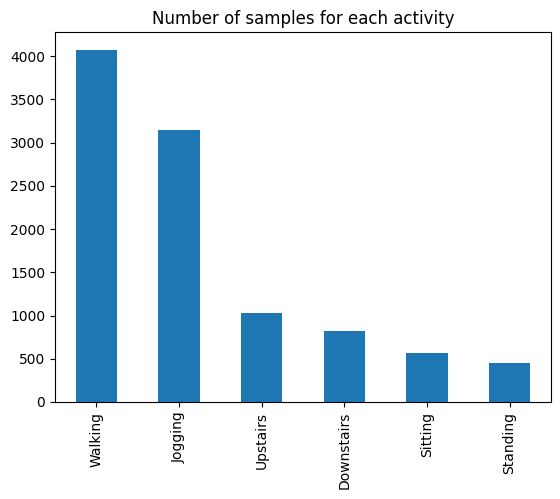

In [14]:
# get the number of samples for each activity
activity_counts = extracted_df['activity_label'].value_counts()
# plot the number of samples for each activity
activity_counts.plot(kind='bar', title='Number of samples for each activity')


As we can see from the plot, the majority of samples are labelled "walking" or "jogging", and very few samples in the "sitting", "standing" categories. We might want to fix this using some sampling methods, to increase the robustness of the model:

In [15]:
# write a function to apply SMOTE to the training data
def apply_smote(X_train, y_train):
    '''
    Apply SMOTE to the training data
    :param X_train: the training features
    :param y_train: the training labels
    :return: the oversampled training features and labels
    '''
    # apply SMOTE
    sm = SMOTE(random_state=42, sampling_strategy='minority', n_jobs=-1)
    X_train, y_train = sm.fit_resample(X_train, y_train)
    # return the new training data
    return X_train, y_train


We will be using 3 different types of cross-validation to ensure the robustness of the model:

#### 10 fold Cross-Validation
First, we will train and test our model using the 10 fold Cross-Validation method:

In [16]:
# initialize the number of folds
num_folds = 10

# get the features and labels
X = extracted_df.drop(['user-id', 'activity_label'], axis=1)

# turn the labels into integers
le = LabelEncoder()
y = le.fit_transform(extracted_df['activity_label'])

# turn X, y into numpy arrays
X = X.values
y = y

# initialize the 10-fold cross validation
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# initialize the list to store the accuracy for each fold
accuracy_list = []
precision = []
recall = []
f1 = []
AUROC = []

# iterate through the folds
for train_index, test_index in tqdm.tqdm(kf.split(X)):
    # initialize the xgboost classifier
    xgb_clf = xgb.XGBClassifier(objective='multi:softproba', num_class=6, n_jobs=-1, 
            subsample= 0.6, reg_alpha= 0.005, n_estimators= 100, min_child_weight= 3, 
            max_depth= 50, learning_rate= 0.1, gamma= 0.4, colsample_bytree= 0.8)
    # get the train and test data
    X_train,X_test=X[train_index],X[test_index]
    y_train,y_test=y[train_index],y[test_index]
    # apply SMOTE to the training data
    X_train, y_train = apply_smote(X_train, y_train)
    # train the model
    xgb_clf.fit(X_train, y_train)
    # get the predictions
    y_pred = xgb_clf.predict(X_test)
    y_pred_proba = xgb_clf.predict_proba(X_test)
    # print("y_pred: ", y_pred)
    # calculate the accuracy
    accuracy = accuracy_score(y_test, y_pred)
    # append the accuracy to the list
    accuracy_list.append(accuracy)
    # calculate the precision
    precision.append(precision_score(y_test, y_pred, average='weighted'))
    # calculate the recall
    recall.append(recall_score(y_test, y_pred, average='weighted'))
    # calculate the f1 score
    f1.append(f1_score(y_test, y_pred, average='weighted'))
    # calculate the AUROC
    AUROC.append(roc_auc_score(y_test, y_pred_proba, average='weighted', multi_class='ovr'))

#print a report of the results of the cross validation (average for 10 folds)
print("Accuracy: ", np.mean(accuracy_list))
print("Precision: ", np.mean(precision))
print("Recall: ", np.mean(recall))
print("F1: ", np.mean(f1))
print("AUROC: ", np.mean(AUROC))


10it [02:15, 13.59s/it]

Accuracy:  0.9792787531266223
Precision:  0.9793328645355928
Recall:  0.9792787531266223
F1:  0.979200840754543
AUROC:  0.9993921995899064


#### Leave-One-Group-Out Cross Validation

Next, we will validate our model using the leave-one-group-out cross validation. Since many users' data do not have all 6 activities, I will group the subject into 9 groups, each group has 4 users. User 1-4, 5-8, ... will be grouped together.

In [17]:
# map the users into their respective groups
user_group_dict = {}
for i in range(1,37):
    user_group_dict[i] = i // 4 + 1
# map the user-id to the group-id
extracted_df['group-id'] = extracted_df['user-id'].map(user_group_dict)

#get the groups
groups = extracted_df['group-id'].values

# leave-one-user-out cross validation
logo = LeaveOneGroupOut()
logo.get_n_splits(X, y, groups)

logo.get_n_splits(groups=groups)

# initialize the list to store the accuracy for each fold
accuracy_list = []
precision = []
recall = []
f1 = []
AUROC = []

# iterate through the folds
for train_index, test_index in tqdm.tqdm(logo.split(X, y, groups)):
    # initialize the xgboost classifier
    xgb_clf = xgb.XGBClassifier(objective='multi:softproba', num_class=6, n_jobs=-1, 
            subsample= 0.6, reg_alpha= 0.005, n_estimators= 100, min_child_weight= 3, 
            max_depth= 50, learning_rate= 0.1, gamma= 0.4, colsample_bytree= 0.8)
    # get the train and test data
    X_train,X_test=X[train_index],X[test_index]
    y_train,y_test=y[train_index],y[test_index]
    # apply SMOTE to the training data
    X_train, y_train = apply_smote(X_train, y_train)
    # train the model
    xgb_clf.fit(X_train, y_train)
    # get the predictions
    y_pred = xgb_clf.predict(X_test)
    y_pred_proba = xgb_clf.predict_proba(X_test)
    # print("unique value in y_pred", np.unique(y_pred))
    # calculate the accuracy
    accuracy = accuracy_score(y_test, y_pred)
    # append the accuracy to the list
    accuracy_list.append(accuracy)
    # calculate the precision
    precision.append(precision_score(y_test, y_pred, average='weighted'))
    # calculate the recall
    recall.append(recall_score(y_test, y_pred, average='weighted'))
    # calculate the f1 score
    f1.append(f1_score(y_test, y_pred, average='weighted'))
    # calculate the AUROC
    AUROC.append(roc_auc_score(y_test, y_pred_proba, average='weighted', multi_class='ovr'))

#print a report of the results of the cross validation (average for 10 folds)
print("Accuracy: ", np.mean(accuracy_list))
print("Precision: ", np.mean(precision))
print("Recall: ", np.mean(recall))
print("F1: ", np.mean(f1))
print("AUROC: ", np.mean(AUROC))



10it [01:56, 11.70s/it]

Accuracy:  0.8981345281871654
Precision:  0.9034395767949752
Recall:  0.8981345281871654
F1:  0.8958296162127015
AUROC:  0.9815789437232697


We see that the performance of the model decreases in the leave-one-group-out CV, which makes sense since we are training the model in one group of users and test it in a complete new group.

#### 29/7 Train-Test Split

Next, we will train the model with the data from first 27 subjects, and test it in the last 9 subjects.

In [41]:
# initialize the xgb classifier
xgb_clf =  xgb.XGBClassifier(objective='multi:softproba', num_class=6, n_jobs=-1, 
            subsample= 0.6, reg_alpha= 0.005, n_estimators= 100, min_child_weight= 3, 
            max_depth= 9, learning_rate= 0.1, gamma= 0.4, colsample_bytree= 0.8)

# get X and y train , the first 27 users
X_train = extracted_df[extracted_df['user-id'] <= 27].drop(['user-id', 'activity_label', 'group-id'], axis=1)
y_train = extracted_df[extracted_df['user-id'] <= 27]['activity_label']

# get X and y test, the last 9 users
X_test = extracted_df[extracted_df['user-id'] > 27].drop(['user-id', 'activity_label', 'group-id'], axis=1)
y_test = extracted_df[extracted_df['user-id'] > 27]['activity_label']

# apply SMOTE to the training data
X_train, y_train = apply_smote(X_train, y_train)

# turn the labels into integers
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

# train the model
xgb_clf.fit(X_train, y_train)

# get the predictions
y_pred = xgb_clf.predict(X_test)
y_pred_proba = xgb_clf.predict_proba(X_test)

# calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)
# calculate the precision
print("Precision: ", precision_score(y_test, y_pred, average='weighted'))
# calculate the recall
print("Recall: ", recall_score(y_test, y_pred, average='weighted'))
# calculate the f1 score
print("F1: ", f1_score(y_test, y_pred, average='weighted'))
# calculate the AUROC
print("AUROC: ", roc_auc_score(y_test, y_pred_proba, average='weighted', multi_class='ovr'))
# transform the predictions into the original labels
y_pred = le.inverse_transform(y_pred)
y_test = le.inverse_transform(y_test)

# get the classification report
print(classification_report(y_test, y_pred))

# get the confusion matrix
cm = confusion_matrix(y_test, y_pred)

Accuracy:  0.8717465107506601
Precision:  0.8740644498319551
Recall:  0.8717465107506601
F1:  0.8702873870563121
AUROC:  0.9574886732962796
              precision    recall  f1-score   support

  Downstairs       0.84      0.68      0.75       245
     Jogging       0.83      0.95      0.89       738
     Sitting       0.88      1.00      0.93       168
    Standing       0.95      0.84      0.89       149
    Upstairs       0.78      0.77      0.77       278
     Walking       0.92      0.87      0.90      1073

    accuracy                           0.87      2651
   macro avg       0.87      0.85      0.86      2651
weighted avg       0.87      0.87      0.87      2651



Text(0.5, 1.0, 'Confusion Matrix')

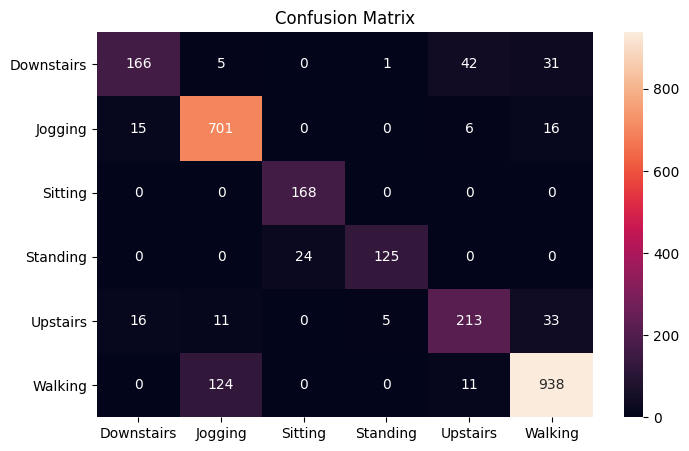

In [42]:
df_cm = pd.DataFrame(cm, index = ["Downstairs", "Jogging", "Sitting", "Standing", "Upstairs", "Walking"],
                  columns = ["Downstairs", "Jogging", "Sitting", "Standing", "Upstairs", "Walking"])

plt.figure(figsize = (8,5))
sns.heatmap(df_cm, annot=True, fmt='g')
# set title
plt.title('Confusion Matrix')

From the three evaluation methods, we can see that our model has a relatively good performance. For the 10-fold cross-validation method, it managed to achieved the accuracy rate of 98%. In the Leave-One-Group-Out (LOGO) cross validation, the accuracy rate is about 90% and in the 29/7 split, the accuracy is around 87%. This makes sense since in the last two evaluation methods, we are making predictions on a different set of users, and xgboost is generally poor in extrapolation. 

However, we can see that even though the accuracy, precision, recal and f1 score decreases from the 10-fold CV to LOGO CV, the AUROC score remains relatively similar. This stems from the facts that we used the soft-predicted labels to calculate the AUROC score, not the hard label. This means that the algorithm did pretty well at ranking data, but there are some uncertainty between classes (for example: jogging vs walking, upstairs vs downstaires, ...) that prevents the model from making definite predictions. 

Let's try to combine two pairs of labels: sitting + standing = still; upstairs + downstairs = stairs and see if this can increase the performances of the model:

In [48]:
# combining sitting and standing label into Still
extracted_df['activity_label'] = extracted_df['activity_label'].replace(['Sitting', 'Standing'], 'Still')
#combininig downstairs and upstairs label into Going Up/Down
extracted_df['activity_label'] = extracted_df['activity_label'].replace(['Downstairs', 'Upstairs'], 'Going Up/Down')

# get X and y train , the first 27 users
X_train = extracted_df[extracted_df['user-id'] <= 27].drop(['user-id', 'activity_label', 'group-id'], axis=1)
y_train = extracted_df[extracted_df['user-id'] <= 27]['activity_label']

# get X and y test, the last 9 users
X_test = extracted_df[extracted_df['user-id'] > 27].drop(['user-id', 'activity_label', 'group-id'], axis=1)
y_test = extracted_df[extracted_df['user-id'] > 27]['activity_label']

# apply SMOTE to the training data
X_train, y_train = apply_smote(X_train, y_train)

# turn the labels into integers
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

# train the model
xgb_clf.fit(X_train, y_train)

# get the predictions
y_pred = xgb_clf.predict(X_test)
y_pred_proba = xgb_clf.predict_proba(X_test)

# calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)
# transform the predictions into the original labels
y_pred = le.inverse_transform(y_pred)
y_test = le.inverse_transform(y_test)

# get the classification report
print(classification_report(y_test, y_pred)) 

Accuracy:  0.9087136929460581
               precision    recall  f1-score   support

Going Up/Down       0.91      0.89      0.90       523
      Jogging       0.83      0.94      0.88       738
        Still       1.00      1.00      1.00       317
      Walking       0.94      0.87      0.91      1073

     accuracy                           0.91      2651
    macro avg       0.92      0.92      0.92      2651
 weighted avg       0.91      0.91      0.91      2651



The accuracy increases to nearly 91% for the 29/7 split validation, which is a big improvement!

### Appendix: Parameter tuning

In this section, I will present the code I used for hyperparameter tuning. Since the dataset is big, I cannot use grid search since it takes a lot of time. I started by using random search instead. However, after playing with it for a while, I believe tuning model parameters did not have a huge impact on the performance, and it takes a very long time to fits all the folds.

In [47]:
# code for hyperparameter tuning for xgboost
# initialize the xgb classifier
xgb_clf = xgb.XGBClassifier(objective='multi:softproba', num_class=6, n_jobs=-1)

# define the parameters to tune
params = { 
    'max_depth': [10, 20, 30, 40, 50],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'n_estimators': [100, 200, 300, 400, 500],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.001, 0.005, 0.01, 0.05]
}

# initialize the random search
rd_search = RandomizedSearchCV(xgb_clf, params, cv=4, n_jobs=-1, verbose=1, n_iter=10)

# fit the grid search
rd_search.fit(X_train, y_train)

# get the best parameters
print(rd_search.best_params_)
# get the best score
print(rd_search.best_score_)
# get the best estimator
print(rd_search.best_estimator_)
# get the best index
print(rd_search.best_index_)
# get the best score
print(rd_search.best_score_)



Fitting 4 folds for each of 10 candidates, totalling 40 fits


KeyboardInterrupt: 